# Auteurs:
*   Arnaud Dalbec-Constant: 2014288
*   Félix Auger: 2067772


In [1]:
from google.colab import drive
import cv2
import numpy as np
from skimage.feature import graycomatrix, graycoprops
from skimage import io, color, img_as_ubyte
import os, os.path
import pandas as pd
import time
from google.colab.patches import cv2_imshow
from scipy.spatial.distance import euclidean
from sklearn.neighbors import KNeighborsClassifier

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path_boxed_test = "/content/drive/MyDrive/INF6804/TP1_boxed_data/"
path_test = "/content/drive/MyDrive/INF6804/TP1_data_test_luminosite/"
path = "/content/drive/MyDrive/INF6804/TP1_data_test_luminosite/database"
boxed_path = "/content/drive/MyDrive/INF6804/TP1_boxed_data/database"

# GLCM properties
def contrast_feature(matrix_coocurrence):
	contrast = graycoprops(matrix_coocurrence, 'contrast')
	return float(contrast)

def dissimilarity_feature(matrix_coocurrence):
	dissimilarity = graycoprops(matrix_coocurrence, 'dissimilarity')
	return float(dissimilarity)

def homogeneity_feature(matrix_coocurrence):
	homogeneity = graycoprops(matrix_coocurrence, 'homogeneity')
	return float(homogeneity)

def energy_feature(matrix_coocurrence):
	energy = graycoprops(matrix_coocurrence, 'energy')
	return float(energy)

def correlation_feature(matrix_coocurrence):
	correlation = graycoprops(matrix_coocurrence, 'correlation')
	return float(correlation)

def asm_feature(matrix_coocurrence):
	asm = graycoprops(matrix_coocurrence, 'ASM')
	return  float(asm)

def kullback_leibler_divergence(p, q):
    p = np.asarray(p)
    q = np.asarray(q)
    filt = np.logical_and(p != 0, q != 0)
    return np.sum(p[filt] * np.log2(p[filt] / q[filt]))

0.8606419753086421
0.3808888888888889
0.850560665271612
0.4870390223558716
0.9508731464125069
0.23720700929736319


# Creation of CM dataset from dataset images

In [9]:
def train_df_generation(path, bins, distance):
  cm_dataframe = pd.DataFrame(columns=['Image', 'Image_type', 'CM'])

  for image in os.listdir(path):
    image_path = path + '/' + image

    im = cv2.imread(image_path)

    im_gray = np.mean(im, axis=2)

    inds = np.digitize(im_gray, bins)
    max_value = inds.max()+1
    matrix_coocurrence = graycomatrix(inds, distances=distance, angles=[135], levels=max_value, normed=False, symmetric=False)
    cm_properties=[]
    cm_properties.append(contrast_feature(matrix_coocurrence))
    cm_properties.append(dissimilarity_feature(matrix_coocurrence))
    cm_properties.append(homogeneity_feature(matrix_coocurrence))
    cm_properties.append(energy_feature(matrix_coocurrence))
    cm_properties.append(correlation_feature(matrix_coocurrence))
    cm_properties.append(asm_feature(matrix_coocurrence))
    cm_dataframe.loc[len(cm_dataframe.index)] = [image, image[:-6], cm_properties]
  return cm_dataframe

def generate_CM_3_best_results(path_test,cm_dataframe, bins, distance):
  # KNN classifier with 5 neighbors
  X = cm_dataframe['CM'].tolist()
  y = cm_dataframe['Image_type'].tolist()
  #__________________________________________________
  # Hyperparameter to play with (n_neighbors)
  neigh = KNeighborsClassifier(n_neighbors = 3)
  neigh.fit(X, y)
  #__________________________________________________

  test_dataframe = pd.DataFrame(columns=
                                        ['test_image',
                                        'CM_pred_KNN',
                                        'CM_pred_KB',
                                        'pred_KNN',
                                        'pred_KB',
                                        'KB_3_best',
                                        'KNN_3_best',
                                        'CM'])

  # Measure CM  for the current image and classify based on dataset images
  start_time = time.time()
  for image in os.listdir(path_test):
    image_path = path_test + '/' + image

    if os.path.splitext(image_path)[1] == ".jpg":
      im_current = cv2.imread(image_path)

      # Preprocessing
      current_im_gray = np.mean(im_current, axis=2)

      # Preprocessing for brightness increase
      """
      brightness_factor = 50
      current_im_gray = np.mean(im_current, axis=2)
      current_im_gray = np.clip(current_im_gray + brightness_factor, 0, 255)
      """

      # CM
      inds = np.digitize(current_im_gray, bins)
      max_value = inds.max()+1
      matrix_coocurrence = graycomatrix(inds, distances=distance, angles=[135], levels=max_value, normed=False, symmetric=False)
      cm_properties=[]
      cm_properties.append(contrast_feature(matrix_coocurrence))
      cm_properties.append(dissimilarity_feature(matrix_coocurrence))
      cm_properties.append(homogeneity_feature(matrix_coocurrence))
      cm_properties.append(energy_feature(matrix_coocurrence))
      cm_properties.append(correlation_feature(matrix_coocurrence))
      cm_properties.append(asm_feature(matrix_coocurrence))

      # Kullback Leibler Divergence score
      best_score = 1e10
      second_best_score = 1e10
      third_best_score = 1e10
      third_best_name = None
      second_best_name = None
      best_name = None
      for i in cm_dataframe.index:
          matrix_coocurrence_ref = cm_dataframe['CM'][i]
          label_ref = cm_dataframe['Image_type'][i]

          score = kullback_leibler_divergence(cm_properties, matrix_coocurrence_ref)
          if (score < best_score):
              third_best_score = second_best_score
              second_best_score = best_score
              best_score = score
              third_best_name = second_best_name
              second_best_name = best_name
              best_name = label_ref

          elif (score < second_best_score):
              third_best_score = second_best_score
              second_best_score = score
              third_best_name = second_best_name
              second_best_name = label_ref

          elif (score < third_best_score):
              third_best_score = score
              third_best_name = label_ref

      # Classification
      label_pred = str(neigh.predict([cm_properties])[0])
      distances, indices = neigh.kneighbors([cm_properties])
      top_3_predictions = np.array([cm_dataframe['Image_type'][i] for i in indices])
      test_dataframe.loc[len(test_dataframe.index)] = [image, top_3_predictions[0][0], best_name, top_3_predictions[0][0] in image, best_name in image,[best_name, second_best_name, third_best_name], top_3_predictions[0], cm_properties]
  print('execution time (s):')
  print(time.time() - start_time)
  print(test_dataframe[['test_image','CM_pred_KNN','pred_KNN','CM_pred_KB','pred_KB','KB_3_best','KNN_3_best']])
  Accuracy = test_dataframe['pred_KNN'].sum() / len(test_dataframe.index) * 100
  print(f'The prediction accuracy with K-NN classifier is ' + str(Accuracy.astype(np.float16)) + '%')
  Accuracy = test_dataframe['pred_KB'].sum() / len(test_dataframe.index) * 100
  print(f'The prediction accuracy with Kullback is ' + str(Accuracy.astype(np.float16)) + '%')
  return test_dataframe


 Get best 3 results for each prediction

In [11]:
bins = np.arange(0,256, 64)
distance = [6]

cm_dataframe = train_df_generation(path, bins, distance)
boxed_cm_dataframe = train_df_generation(boxed_path, bins, distance)

test_dataframe = generate_CM_3_best_results(path_boxed_test, cm_dataframe, bins, distance)
boxed_test_dataframe = generate_CM_3_best_results(path_boxed_test, boxed_cm_dataframe, bins, distance)

0.46471095085144043
             test_image CM_pred_KNN  pred_KNN CM_pred_KB  pred_KB  \
0  strawberry_query.jpg       dolph     False       ball    False   
1    airplane_query.jpg    airplane      True       ball    False   
2        ball_query.jpg        face     False       ball     True   
3         car_query.jpg         cat     False       ball    False   
4         cat_query.jpg         cat      True        cat     True   
5     dolphin_query.jpg        face     False       ball    False   
6        face_query.jpg       lotus     False       ball    False   
7       lotus_query.jpg    airplane     False       ball    False   
8     pickles_query.jpg     pickles      True       ball    False   

                  KB_3_best                   KNN_3_best  
0    [ball, dolphin, lotus]   [dolph, dolphin, airplane]  
1     [ball, ball, dolphin]       [airplane, face, face]  
2       [ball, lotus, ball]        [face, ball, dolphin]  
3    [ball, dolphin, lotus]            [cat, lotus, c

In [18]:
# Save previous results
test_dataframe.to_csv('/content/drive/MyDrive/INF6804/best_results_CM.csv')
boxed_test_dataframe.to_csv('/content/drive/MyDrive/INF6804/best_results_CM_boxed.csv')

## Functions for hyperparameter grid search

In [25]:
def generate_CM_results(path_test,cm_dataframe, bins, distances):
  # KNN classifier with 5 neighbors
  X = cm_dataframe['CM'].tolist()
  y = cm_dataframe['Image_type'].tolist()

  test_dataframe = pd.DataFrame(columns=
            ['test_image',
            'CM_prediction_KNN',
            'CM_prediction_KB',
            'is_pred_true_KNN',
            'is_pred_true_KB',
            'CM'])

  #__________________________________________________
  # Hyperparameter to play with (n_neighbors)
  neigh = KNeighborsClassifier(n_neighbors = 1)
  neigh.fit(X, y)
  #__________________________________________________

  # Measure CM  for the current image and classify based on dataset images

  for image in os.listdir(path_test):
    image_path = path_test + '/' + image

    if os.path.splitext(image_path)[1] == ".jpg":
      im_current = cv2.imread(image_path)

      # Preprocessing
      current_im_gray = np.mean(im_current, axis=2)

      # CM
      inds = np.digitize(current_im_gray, bins)
      max_value = inds.max()+1
      matrix_coocurrence = graycomatrix(inds, distances=distances, angles=[0], levels=max_value, normed=False, symmetric=False)
      cm_properties=[]
      cm_properties.append(contrast_feature(matrix_coocurrence))
      cm_properties.append(dissimilarity_feature(matrix_coocurrence))
      cm_properties.append(homogeneity_feature(matrix_coocurrence))
      cm_properties.append(energy_feature(matrix_coocurrence))
      cm_properties.append(correlation_feature(matrix_coocurrence))
      cm_properties.append(asm_feature(matrix_coocurrence))

      # Kullback Leibler Divergence score
      best_score = 1e8
      for i in cm_dataframe.index:
          matrix_coocurrence_ref = cm_dataframe['CM'][i]
          label_ref = cm_dataframe['Image_type'][i]

          score = kullback_leibler_divergence(cm_properties, matrix_coocurrence_ref)
          if score < best_score:
              best_score = score
              best_name = label_ref

      # Classification
      label_pred = str(neigh.predict([cm_properties])[0])

      test_dataframe.loc[len(test_dataframe.index)] = [image, label_pred, best_name, label_pred in image, best_name in image, cm_properties]

  print(test_dataframe[['test_image','CM_prediction_KNN','is_pred_true_KNN','CM_prediction_KB','is_pred_true_KB']])
  Accuracy = test_dataframe['is_pred_true_KNN'].sum() / len(test_dataframe.index) * 100
  print(f'The prediction accuracy with K-NN classifier is ' + str(Accuracy.astype(np.float16)) + '%')
  Accuracy = test_dataframe['is_pred_true_KB'].sum() / len(test_dataframe.index) * 100
  print(f'The prediction accuracy with Kullback is ' + str(Accuracy.astype(np.float16)) + '%')
  return test_dataframe

In [26]:
# Hyperparameters list
bins_bit_list = [4, 8, 12, 16, 20, 24, 28, 32, 40, 48, 56, 64]
distances_list=[1,2,4,6]

result_df = pd.DataFrame(columns = ['distance','bins_bit', 'Acc_KNN', 'Acc_KB', 'box_Acc_KNN','box_Acc_KB'])
for distances in distances_list:
  distances_array = [distances]
  for bins_bit in bins_bit_list:
      bins = np.arange(0,256, bins_bit)

      print(f'running with hyperparameters: bins_bit:{bins_bit} and distance {distances}')
      CM_dataframe = train_df_generation(path, bins, distances_array)
      boxed_CM_dataframe = train_df_generation(boxed_path, bins, distances_array)

      test_dataframe = generate_CM_results(path_test, CM_dataframe, bins, distances_array)
      boxed_test_dataframe = generate_CM_results(path_boxed_test, boxed_CM_dataframe, bins, distances_array)

      Accuracy_KNN = test_dataframe['is_pred_true_KNN'].sum() / len(test_dataframe.index) * 100
      Accuracy_KB = test_dataframe['is_pred_true_KB'].sum() / len(test_dataframe.index) * 100
      boxed_Accuracy_KNN = boxed_test_dataframe['is_pred_true_KNN'].sum() / len(boxed_test_dataframe.index) * 100
      boxed_Accuracy_KB = boxed_test_dataframe['is_pred_true_KB'].sum() / len(boxed_test_dataframe.index) * 100

      result_df.loc[len(result_df.index)] = [distances,
                                             bins_bit,
                                             Accuracy_KNN,
                                             Accuracy_KB,
                                             boxed_Accuracy_KNN,
                                             boxed_Accuracy_KB]


running with hyperparameters: bins_bit:4 and distance 1
             test_image CM_prediction_KNN  is_pred_true_KNN CM_prediction_KB  \
0         car_query.jpg               car              True              cat   
1    airplane_query.jpg              face             False              cat   
2  strawberry_query.jpg               car             False              cat   
3     dolphin_query.jpg               car             False              cat   
4        face_query.jpg          airplane             False              cat   
5        ball_query.jpg              ball              True              cat   
6         cat_query.jpg             lotus             False              cat   
7       lotus_query.jpg               car             False              cat   
8     pickles_query.jpg           pickles              True             ball   

   is_pred_true_KB  
0            False  
1            False  
2            False  
3            False  
4            False  
5            Fals

In [27]:
# Save results as CSV
result_df.to_csv('/content/drive/MyDrive/INF6804/Hyperparameter_gridsearch_CM_KNN1_v3.csv')

### GridSearch visualization

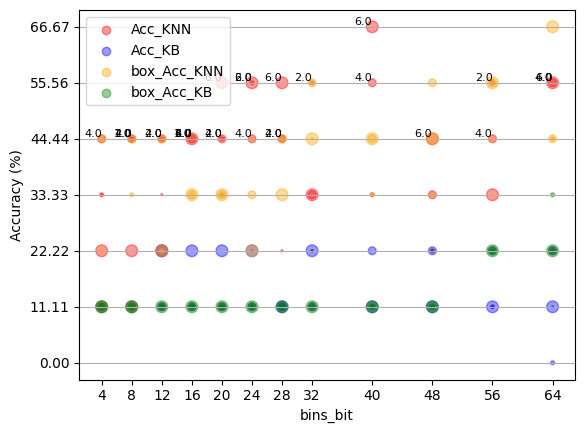

In [28]:
import matplotlib.pyplot as plt
colors = {
    'Acc_KNN': 'red',
    'Acc_KB': 'blue',
    'box_Acc_KNN': 'orange',
    'box_Acc_KB': 'green'
}
plt.scatter(result_df['bins_bit'], result_df['Acc_KNN'], label='Acc_KNN',s=2*(result_df['distance'])**2,color = colors['Acc_KNN'],alpha = 0.4)
plt.scatter(result_df['bins_bit'], result_df['Acc_KB'], label='Acc_KB',s=2*(result_df['distance'])**2,color = colors['Acc_KB'],alpha = 0.4)
plt.scatter(result_df['bins_bit'], result_df['box_Acc_KNN'], label='box_Acc_KNN',s=2*(result_df['distance'])**2,color = colors['box_Acc_KNN'],alpha = 0.4)
plt.scatter(result_df['bins_bit'], result_df['box_Acc_KB'], label='box_Acc_KB',s=2*(result_df['distance'])**2,color = colors['box_Acc_KB'],alpha = 0.4)
plt.xlabel('bins_bit')
plt.ylabel('Accuracy (%)')
unique_y_values = pd.concat([
    result_df['Acc_KNN'],
    result_df['Acc_KB'],
    result_df['box_Acc_KNN'],
    result_df['box_Acc_KB']
]).unique()
unique_x_values = result_df['bins_bit'].unique()
plt.yticks(unique_y_values)
plt.xticks(unique_x_values)
texts = []
for i, txt in enumerate(result_df.iterrows()):
    if txt[1]['Acc_KNN'] >= 40:
        plt.text(txt[1]['bins_bit'], txt[1]['Acc_KNN'], f"{txt[1]['distance']}", ha='right', va='bottom', color='black', fontsize=8)
    if txt[1]['Acc_KB'] >= 40:
        plt.text(txt[1]['bins_bit'], txt[1]['Acc_KB'], f"{txt[1]['distance']}", ha='right', va='bottom', color='black', fontsize=8)

plt.grid(which='both', axis='y')
plt.legend()
plt.show()